<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC1_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
%pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import shap

# Imports

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
sns.set_palette('colorblind')

# Data Preparation

In [ ]:
# Dataset Download 
os.system('git clone https://github.com/arthursl12/dataset_2')
os.system('mv /content/dataset_2/CMaps /content/CMaps')
os.system('mv /content/dataset_2/data_processing /content/data_processing')
os.system('rm -rf dataset_2')

0

In [ ]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [ ]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [ ]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(1)
train

unit_number  time    op_1    op_2   op_3     s_0     s_1      s_2  \
0                1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70   
1                1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82   
2                1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99   
3                1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79   
4                1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85   
...            ...   ...     ...     ...    ...     ...     ...      ...   
20626          100   196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98   
20627          100   197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50   
20628          100   198  0.0004  0.0000  100.0  518.67  643.42  1602.46   
20629          100   199 -0.0011  0.0003  100.0  518.67  643.23  1605.26   
20630          100   200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38   

           s_3    s_4  ...    s_11     s_12     s_13    s_14  s_15  s_16  \
0      1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1      1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2      1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3      1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4      1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   
...        ...    ...  ...     ...      ...      ...     ...   ...   ...   
20626  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956  0.03   397   
20627  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139  0.03   395   
20628  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646  0.03   398   
20629  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389  0.03   395   
20630  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036  0.03   396   

       s_17   s_18   s_19     s_20  
0      2388  100.0  39.06  23.4190  
1      2388  100.0  39.00  23.4236  
2      2388  100.0  38.95  23.3442  
3      2388  100.0  38.88  23.3739  
4      2388  100.0  38.90  23.4044  
...     ...    ...    ...      ...  
20626  2388  100.0  38.49  22.9735  
20627  2388  100.0  38.30  23.1594  
20628  2388  100.0  38.44  22.9333  
20629  2388  100.0  38.29  23.0640  
20630  2388  100.0  38.37  23.0522  

[20631 rows x 26 columns]

## Preprocessing

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [ ]:
test.shape, y_test.shape

((13096, 26), (100, 1))

In [ ]:
test_last = proc.transform_test(test)
test_last.head()

s_0     s_1      s_2      s_3    s_4    s_5     s_6      s_7      s_8  \
0  518.67  642.58  1581.22  1398.91  14.62  21.61  554.42  2388.08  9056.40   
1  518.67  642.55  1586.59  1410.83  14.62  21.61  553.52  2388.10  9044.77   
2  518.67  642.88  1589.75  1418.89  14.62  21.61  552.59  2388.16  9049.26   
3  518.67  642.78  1594.53  1406.88  14.62  21.61  552.64  2388.13  9051.30   
4  518.67  642.27  1589.94  1419.36  14.62  21.61  553.29  2388.10  9053.99   

   s_9  ...    s_11     s_12     s_13    s_14  s_15  s_16  s_17   s_18   s_19  \
0  1.3  ...  521.79  2388.06  8130.11  8.4024  0.03   393  2388  100.0  38.81   
1  1.3  ...  521.74  2388.09  8126.90  8.4505  0.03   391  2388  100.0  38.81   
2  1.3  ...  520.83  2388.14  8131.46  8.4119  0.03   395  2388  100.0  38.93   
3  1.3  ...  521.88  2388.11  8133.64  8.4634  0.03   395  2388  100.0  38.58   
4  1.3  ...  521.00  2388.15  8125.74  8.4362  0.03   394  2388  100.0  38.75   

      s_20  
0  23.3552  
1  23.2618  
2  23.2740  
3  23.2581  
4  23.4117  

[5 rows x 21 columns]

In [ ]:
X_test = test_last

### Remaining Useful Life (RUL)

In [ ]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

unit_number  time  RUL
0            1     1  191
1            1     2  190
2            1     3  189
3            1     4  188
4            1     5  187

## Attributes and target separation

In [ ]:
X_train, y_train = proc.X_y_train_divide(train)

In [ ]:
y_train.head()

RUL
0  191
1  190
2  189
3  188
4  187

In [ ]:
X_train.head()

s_0     s_1      s_2      s_3    s_4    s_5     s_6      s_7      s_8  \
0  518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06  9046.19   
1  518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04  9044.07   
2  518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08  9052.94   
3  518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11  9049.48   
4  518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06  9055.15   

   s_9  ...    s_11     s_12     s_13    s_14  s_15  s_16  s_17   s_18   s_19  \
0  1.3  ...  521.66  2388.02  8138.62  8.4195  0.03   392  2388  100.0  39.06   
1  1.3  ...  522.28  2388.07  8131.49  8.4318  0.03   392  2388  100.0  39.00   
2  1.3  ...  522.42  2388.03  8133.23  8.4178  0.03   390  2388  100.0  38.95   
3  1.3  ...  522.86  2388.08  8133.83  8.3682  0.03   392  2388  100.0  38.88   
4  1.3  ...  522.19  2388.04  8133.80  8.4294  0.03   393  2388  100.0  38.90   

      s_20  
0  23.4190  
1  23.4236  
2  23.3442  
3  23.3739  
4  23.4044  

[5 rows x 21 columns]

## Training and Evaluation functions

In [ ]:
eval = Evaluation()

In [ ]:
search = HyperparameterSearch()

# RandomForest (Poly)

In [ ]:
model = Pipeline([
    ('poly_ft', PolynomialFeatures(degree=3, include_bias=False,
                                    interaction_only=True)),
    ('trf_reg' ,TransformedTargetRegressor(
        check_inverse=False,
        regressor   = RandomForestRegressor(ccp_alpha=0.15,
                        max_depth=50,
                        max_features='log2',
                        min_impurity_decrease=5.6,
                        min_samples_leaf=5,
                        n_estimators=200,
                        n_jobs=-1,
                        oob_score=True,
                        random_state=42),
        transformer = FunctionTransformer(np.clip, 
                                          kw_args={'a_min':0,'a_max':99})))
])
model

Pipeline(steps=[('poly_ft',
                 PolynomialFeatures(degree=3, include_bias=False,
                                    interaction_only=True)),
                ('trf_reg',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=RandomForestRegressor(ccp_alpha=0.15,
                                                                            max_depth=50,
                                                                            max_features='log2',
                                                                            min_impurity_decrease=5.6,
                                                                            min_samples_leaf=5,
                                                                            n_estimators=200,
                                                                            n_jobs=-1,
                                                                            oob_score=True,
 

In [ ]:
# ~3min
model.fit(X_train, y_train)
reclipped_y =  model['trf_reg'].transformer.transform(y_train)
eval.show_result(reclipped_y, model.predict(X_train))
eval.show_result_cv(reclipped_y, X_train, model)

R2=0.829,RMSE=-13.170
(CV) R2=0.821,RMSE=-13.461


In [ ]:
reclipped_y =  model['trf_reg'].transformer.transform(y_test)
eval.show_result(reclipped_y, model.predict(X_test))

R2=0.838,RMSE=-13.609


In [ ]:
X_train_transformed = X_train.copy()
X_train_transformed = pd.DataFrame(
                model['poly_ft'].transform(X_train_transformed),
                columns=model['poly_ft'].get_feature_names_out()
)
model['trf_reg'].regressor.fit(X_train_transformed,model['trf_reg'].transformer.transform(y_train))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(ccp_alpha=0.15, max_depth=50, max_features='log2',
                      min_impurity_decrease=5.6, min_samples_leaf=5,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=42)

In [ ]:
sorted(list(zip(model['trf_reg'].regressor.feature_importances_,model['poly_ft'].get_feature_names_out())), reverse=True)[:5]

In [89]:
np.argmin(model['trf_reg'].regressor.predict(X_train_transformed))

472

## SHAP

In [71]:
explainer = shap.TreeExplainer(model['trf_reg'].regressor)
shap_values = explainer.shap_values(X_train_transformed)
explainer.expected_value[0]

In [84]:
ft_names = model['poly_ft'].get_feature_names_out()

In [90]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[472], feature_names=ft_names)

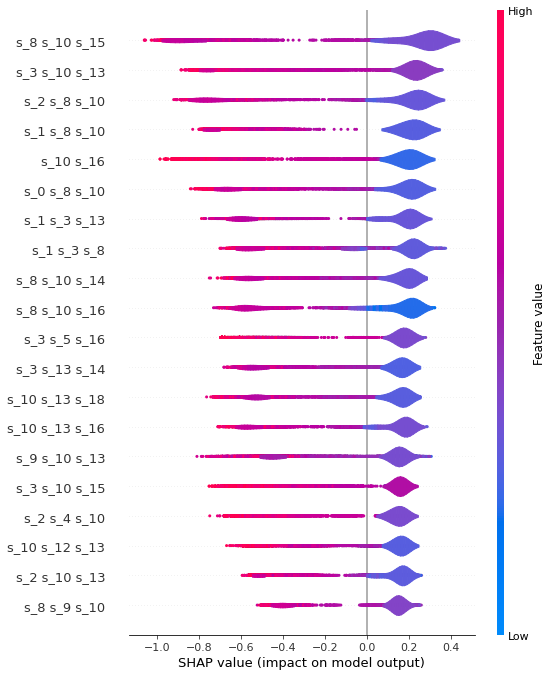

In [72]:
shap.initjs()
shap.summary_plot(shap_values, X_train_transformed, plot_type="violin")

# DecisionTree 

## Model

In [91]:
model = Pipeline([
    ('trf_reg' ,TransformedTargetRegressor(
        check_inverse=False,
        regressor   = DecisionTreeRegressor(ccp_alpha=0.375,
                            criterion='friedman_mse',
                            max_depth=200,
                            max_features='sqrt',
                            min_impurity_decrease=5.5,
                            min_samples_leaf=10,
                            random_state=42),
        transformer = FunctionTransformer(np.clip, 
                                          kw_args={'a_min':0,'a_max':98})))
    ])
model

Pipeline(steps=[('trf_reg',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=DecisionTreeRegressor(ccp_alpha=0.375,
                                                                            criterion='friedman_mse',
                                                                            max_depth=200,
                                                                            max_features='sqrt',
                                                                            min_impurity_decrease=5.5,
                                                                            min_samples_leaf=10,
                                                                            random_state=42),
                                            transformer=FunctionTransformer(func=<function clip at 0x7f8b151dec20>,
                                                                            kw_args={'a_max': 98,
                

In [92]:
model.fit(X_train, y_train)
reclipped_y =  model['trf_reg'].transformer.transform(y_train)
eval.show_result(reclipped_y, model.predict(X_train))
eval.show_result_cv(reclipped_y, X_train, model)

R2=0.815,RMSE=-13.536
(CV) R2=0.781,RMSE=-14.680


In [93]:
reclipped_y =  model['trf_reg'].transformer.transform(y_test)
eval.show_result(reclipped_y, model.predict(X_test))

R2=0.819,RMSE=-14.277


## SHAP

In [94]:
feature_names = X_train.columns
model['trf_reg'].regressor.fit(X_train,model['trf_reg'].transformer.transform(y_train))

DecisionTreeRegressor(ccp_alpha=0.375, criterion='friedman_mse', max_depth=200,
                      max_features='sqrt', min_impurity_decrease=5.5,
                      min_samples_leaf=10, random_state=42)

In [99]:
explainer = shap.TreeExplainer(model['trf_reg'].regressor)
shap_values = explainer.shap_values(X_train)
explainer.expected_value[0]

74.48684019194417

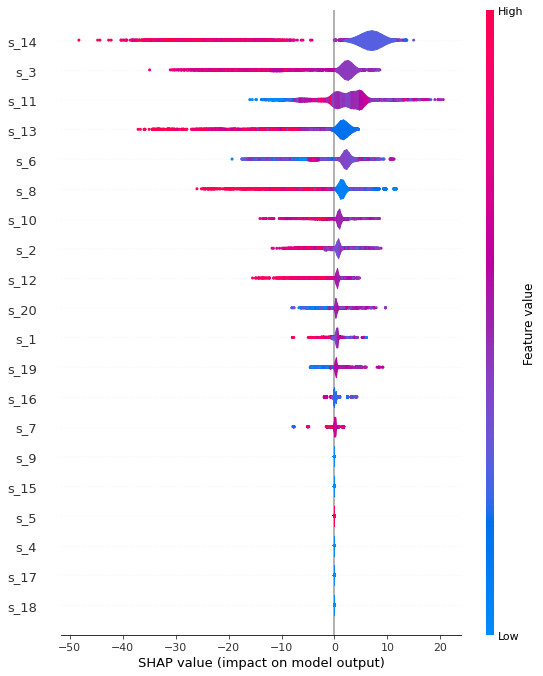

In [100]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="violin")

In [109]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[472], feature_names=ft_names)

In [111]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1], feature_names=ft_names)

In [139]:
def shap_plot_unit(i, shap_values=shap_values, explainer=explainer, feature_names=feature_names, train=train):
    shap.initjs()
    grouped = train.groupby("unit_number").count()["time"]
    start = np.sum(grouped[:i-1])
    end = start + grouped[i]
    return shap.force_plot(explainer.expected_value, 
                    shap_values[start:end], 
                    feature_names=feature_names)

In [141]:
shap_plot_unit(2)

In [124]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[192:192+287], feature_names=ft_names)

# OFF

In [ ]:
explainer = shap.KernelExplainer(model.predict, X_train.head(10))

X does not have valid feature names, but PolynomialFeatures was fitted with feature names


In [ ]:
samples = X_train.head(10)
samples = pd.DataFrame(
                model['poly_ft'].transform(samples),
                columns=model['poly_ft'].get_feature_names_out()
)

In [ ]:
samples

s_0     s_1      s_2      s_3    s_4    s_5     s_6      s_7      s_8  \
0  518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06  9046.19   
1  518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04  9044.07   
2  518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08  9052.94   
3  518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11  9049.48   
4  518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06  9055.15   
5  518.67  642.10  1584.47  1398.37  14.62  21.61  554.67  2388.02  9049.68   
6  518.67  642.48  1592.32  1397.77  14.62  21.61  554.34  2388.02  9059.13   
7  518.67  642.56  1582.96  1400.97  14.62  21.61  553.85  2388.00  9040.80   
8  518.67  642.12  1590.98  1394.80  14.62  21.61  553.69  2388.05  9046.46   
9  518.67  641.71  1591.24  1400.46  14.62  21.61  553.59  2388.05  9051.70   

   s_9  ...  s_16 s_17 s_18  s_16 s_17 s_19  s_16 s_17 s_20  s_16 s_18 s_19  \
0  1.3  ...      93609600.0     36563909.76    2.192243e+07       1531152.0   
1  1.3  ...      93609600.0     36507744.00    2.192674e+07       1528800.0   
2  1.3  ...      93132000.0     36274914.00    2.174092e+07       1519050.0   
3  1.3  ...      93609600.0     36395412.48    2.188021e+07       1524096.0   
4  1.3  ...      93848400.0     36507027.60    2.196465e+07       1528770.0   
5  1.3  ...      93370800.0     36395937.84    2.181786e+07       1524118.0   
6  1.3  ...      93609600.0     36601353.60    2.188349e+07       1532720.0   
7  1.3  ...      93370800.0     36386600.76    2.176529e+07       1523727.0   
8  1.3  ...      93609600.0     36554548.80    2.191082e+07       1530760.0   
9  1.3  ...      93848400.0     36553951.80    2.202566e+07       1530735.0   

   s_16 s_18 s_20  s_16 s_19 s_20  s_17 s_18 s_19  s_17 s_18 s_20  \
0       918024.80   358580.486880       9327528.0      5592457.20   
1       918205.12   358099.996800       9313200.0      5593555.68   
2       910423.80   354610.070100       9301260.0      5574594.96   
3       916256.88   356240.674944       9284544.0      5581687.32   
4       919792.92   357799.445880       9289320.0      5588970.72   
5       913645.79   356139.128942       9308424.0      5580015.72   
6       916394.08   358310.085280       9337080.0      5582523.12   
7       911444.46   355189.906062       9306036.0      5566571.28   
8       917538.72   358298.870160       9325140.0      5589496.08   
9       922347.42   359254.320090       9301260.0      5604492.72   

   s_17 s_19 s_20  s_18 s_19 s_20  
0    2.184414e+06      91474.6140  
1    2.181487e+06      91352.0400  
2    2.171305e+06      90925.6590  
3    2.170160e+06      90877.7232  
4    2.174110e+06      91043.1160  
5    2.175090e+06      91084.1762  
6    2.182767e+06      91405.6340  
7    2.169293e+06      90841.4082  
8    2.182698e+06      91402.7730  
9    2.182950e+06      91413.3130  

[10 rows x 1561 columns]

In [ ]:
explainer = shap.KernelExplainer(model['trf_reg'].predict, samples)

In [ ]:
model['trf_reg'].regressor

RandomForestRegressor(ccp_alpha=0.15, max_depth=50, max_features='log2',
                      min_impurity_decrease=5.6, min_samples_leaf=5,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=42)

In [ ]:
dir(model['trf_reg'].regressor)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score_and_attributes',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'bootstrap',
 'ccp_a

In [ ]:
model['trf_reg'].regressor.get_feature_names_in()

AttributeError: ignored

[(0.017824549135541302, 's_8 s_10 s_15'),
 (0.015272133376661296, 's_10 s_16'),
 (0.014262856935482572, 's_2 s_8 s_10'),
 (0.014227569644719608, 's_3 s_10 s_13'),
 (0.013742716688777235, 's_1 s_8 s_10')]

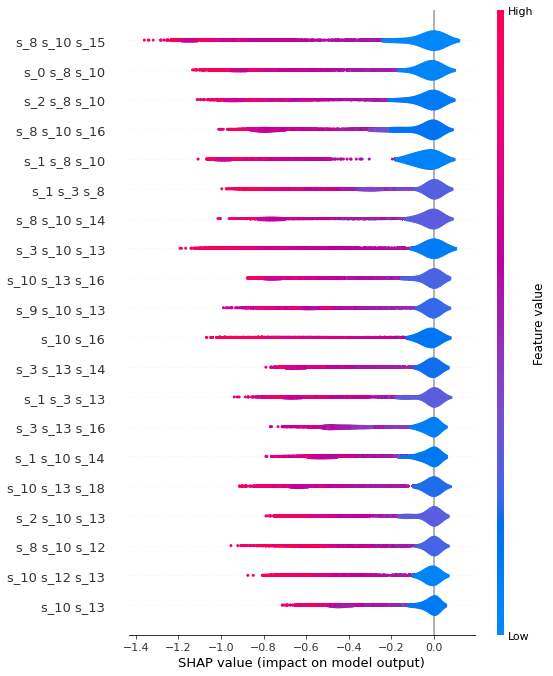

In [ ]:
shap.initjs()

# print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

shap.summary_plot(shap_values, X_train_transformed, plot_type="violin")

In [65]:
explainer.expected_value

95.20969624649913

In [66]:
shap_values

.values =
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.26496781, -0.12253053],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.26496781, -0.12253053],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.26496781, -0.12253053]])

.base_values =
array([95.20969625, 95.20969625, 95.20969625, ..., 95.20969625,
       95.20969625, 95.20969625])

.data =
array([[5.18670000e+02, 6.41820000e+02, 1.58970000e+03, ...,
        5.59245720e+06, 2.18441378e+06, 9.14746140e+04],
       [5.18670000e+02, 6.42150000e+02, 1.59182000e+03, ...,
        5.59355568e+06, 2.18148672e+06, 9.13520400e+04],
       [5.18670000

In [68]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1], X_train_transformed[1])

KeyError: ignored

In [ ]:
shap_values = explainer.shap_values(samples, normalize=False)

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


KeyboardInterrupt: ignored

In [ ]:
# shap_values = explainer(X_train.head(10))
shap_values = explainer.shap_values(X_train.head(10))

  0%|          | 0/10 [00:00<?, ?it/s]

X does not have valid feature names, but PolynomialFeatures was fitted with feature names
X does not have valid feature names, but PolynomialFeatures was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but PolynomialFeatures was fitted with feature names
X does not have valid feature names, but PolynomialFeatures was fitted with feature names
The default o

In [ ]:
shap_values

[array([[ 0.        ,  0.02824034,  0.        ,  0.02103773,  0.        ,
          0.        ,  0.00357755,  0.        ,  0.02586636,  0.        ,
         -0.2589323 ,  0.        ,  0.        , -0.09166558,  0.05036292,
          0.        ,  0.01843146,  0.        ,  0.        ,  0.00596536,
          0.006809  ],
        [ 0.        ,  0.00774796, -0.08963887,  0.02928022,  0.        ,
          0.        ,  0.00590004,  0.        ,  0.05031866,  0.        ,
         -0.42979368, -0.00137401,  0.        ,  0.04453702, -0.15735929,
          0.        ,  0.03649567,  0.        ,  0.        ,  0.00813245,
          0.01235926],
        [ 0.        , -0.00777357,  0.03414447, -0.01411406,  0.        ,
          0.        ,  0.00259939,  0.        , -0.00567023,  0.        ,
          0.09598862, -0.00081253,  0.        ,  0.00174351,  0.02286904,
          0.        ,  0.01790011,  0.        ,  0.        , -0.00498671,
         -0.01485001],
        [ 0.        , -0.00791117,  0.03507

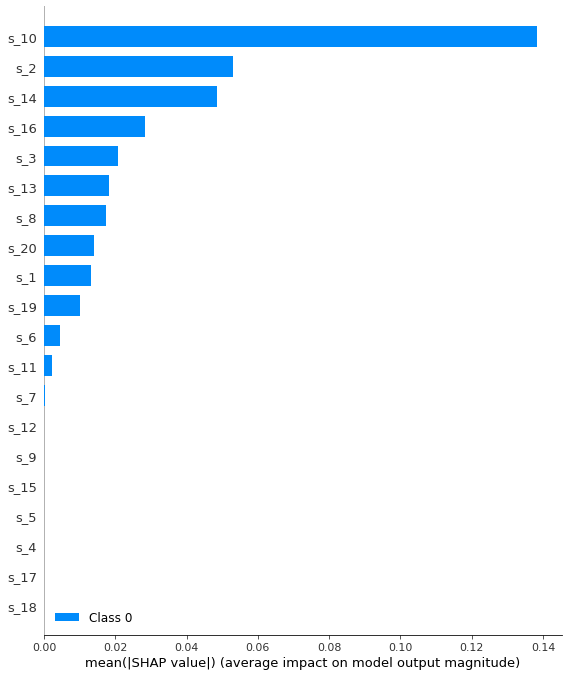

In [ ]:
shap.initjs()

# print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

shap.summary_plot(shap_values, X_train.head(10))

In [ ]:
explainer = shap.KernelExplainer(model.predict, X_train.head(10))
shap_values = explainer.shap_values(X_train.head(10));
shap_obj = explainer(X_train.head(10))

X does not have valid feature names, but PolynomialFeatures was fitted with feature names


  0%|          | 0/10 [00:00<?, ?it/s]

X does not have valid feature names, but PolynomialFeatures was fitted with feature names
X does not have valid feature names, but PolynomialFeatures was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but PolynomialFeatures was fitted with feature names
X does not have valid feature names, but PolynomialFeatures was fitted with feature names
The default o

AttributeError: ignored

In [ ]:
shap.plots.beeswarm(shap_obj)

ValueError: ignored

In [ ]:
explainer = shap.Explainer(model)

TypeError: ignored

In [ ]:
explainer = shap.Explainer(fitted)
shap_values = explainer(X)

TypeError: ignored

In [ ]:
explainer = shap.KernelExplainer(model = model.predict, data = X_train.head(50), link = "identity")

In [ ]:
shap_values = explainer.shap_values(X = X.iloc[0:50,:], nsamples = 100)